### Tutorial on model fitting by Anne Urai, Leiden University (2021).

Based on a tutorial on computational modeling and statistical model fitting as a part the *Trends in Computational Neuroscience* graduate course of the University of Geneva (March-April 2020) by [Luigi Acerbi](http://luigiacerbi.com/).

**Instructions:** 
- In [Google Colab](https://colab.research.google.com/), open the link to this Jupyter notebook
    - To run this notebook locally, you will need standard scientific Python 3.x installation with Jupyter notebook (such as [Anaconda](https://www.anaconda.com/distribution/)). 
- You will also need the `CMA-ES` optimization algorithm (see [here](https://github.com/CMA-ES/pycma)). You can install CMA-ES from the command line with `pip install cma`.
    - In Google Colab, do this by adding a cell with `%pip install cma` before importing.

**Initial setup and loading the data:**

In [2]:
# for running in Google Colab
%pip install cma 

Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.stats import norm
import cma

During this tutorial, we are going to use data from the [International Brain Laboratory](https://www.internationalbrainlab.com/) publicly released behavioral mouse dataset, from exemplar mouse `KS014`. See [this paper](https://elifesciences.org/articles/63711) for more information about the task and datasets. These data can also be inspected via the IBL DataJoint public interface [here](https://data.internationalbrainlab.org/mouse/18a54f60-534b-4ed5-8bda-b434079b8ab8).

For convenience, the data of all behavioral sessions from examplar mouse `KS014` have been already downloaded in the `data` folder and slightly preprocessed into two `.csv` files, one for the training sessions (`KS014_train.csv`) and one with the *biased* sessions (`KS014_biased.csv`). 

We begin our tutorial by examining the training sessions. 

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/anne-urai/tics-2020-tutorial/master/data/KS014_train.csv')  # Load .csv file into a pandas DataFrame

df['signed_contrast'] = df['contrast']*df['position']   # We define a new column for "signed contrasts"
df.drop(columns='stim_probability_left', inplace=True)  # Stimulus probability has no meaning for training sessions

print('Total # of trials: ' + str(len(df['trial_num'])))
print('Sessions: ' + str(np.unique(df['session_num'])))
df.head()

Total # of trials: 10310
Sessions: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


,trial_num,session_num,contrast,position,response_choice,trial_correct,reaction_time,signed_contrast
0,1,1,100.0,-1.0,-1,1.0,1.052300,-100.0
1,2,1,50.0,1.0,1,1.0,0.276001,50.0
2,3,1,50.0,1.0,-1,0.0,2.094101,50.0
3,4,1,50.0,-1.0,1,0.0,3.407901,-50.0
4,5,1,50.0,1.0,1,1.0,1.601400,50.0


**Inspecting the data:**

The first thing to do with any dataset is to get familiar with it by running simple visualizations. Just plot stuff!
For example, as a starter we plot data from individual sessions using a *scatterplot* format (perhaps not the best). What can we see from here?

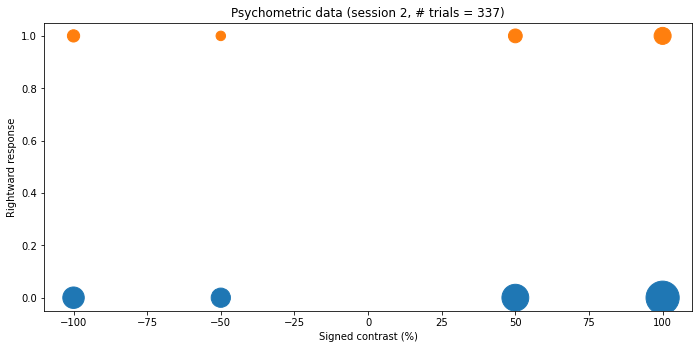

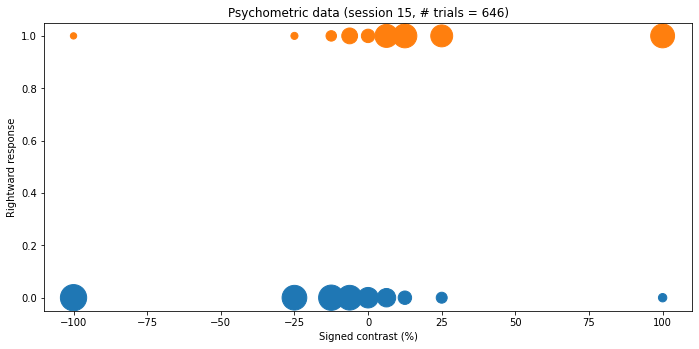

In [8]:
def scatterplot_psychometric_data(df,session_num=None,ax=None):
    """Plot psychometric data (optionally, of a chosen training session) as a scatter plot."""
    
    if session_num == None:
        trial_mask = np.ones(len(df['session_num']), dtype=bool) # Select all trials
    else:
        trial_mask = df['session_num'] == session_num # Indexes of trials of the chosen session
    Ntrials = np.sum(trial_mask) # Number of chosen trials
    
    # Count "left" and "right" responses for each signed contrast level
    left_resp = df[(df['response_choice'] == -1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']
    right_resp = df[(df['response_choice'] == 1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']    
    
    if ax == None:
        ax=fig.add_axes([0,0,1,1])
    ax.scatter(left_resp.index,np.zeros(len(left_resp.index)), s=left_resp*10);
    ax.scatter(right_resp.index,np.ones(len(right_resp.index)), s=right_resp*10);
    ax.set_xlabel('Signed contrast (%)')
    ax.set_ylabel('Rightward response')
    if session_num == None:
        ax.set_title('Psychometric data (# trials = ' + str(Ntrials) + ')')        
    else:
        ax.set_title('Psychometric data (session ' + str(session_num) + ', # trials = ' + str(Ntrials) + ')')        
    return ax

# Plot 2nd session
fig = plt.figure(figsize=(9,4))
scatterplot_psychometric_data(df,2)
plt.show()

# Plot 15th session (last training session)
fig = plt.figure(figsize=(9,4))
scatterplot_psychometric_data(df,15)
plt.show()

We plot the same data again, this time with a different type of plot which may be more informative.

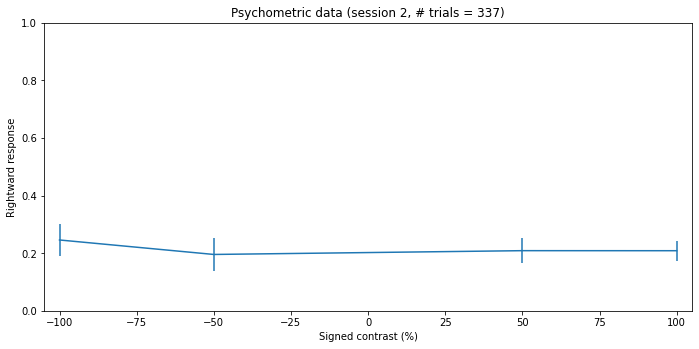

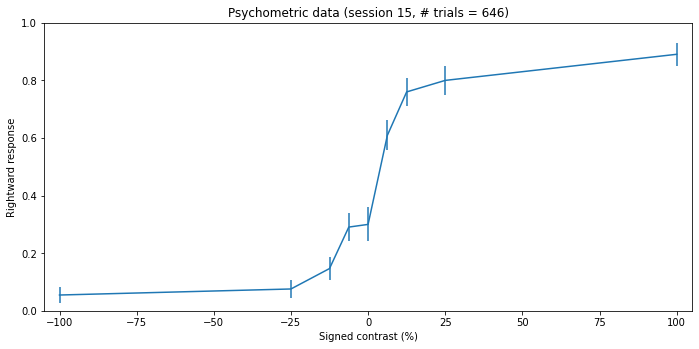

In [10]:
def plot_psychometric_data(df,session_num=None,ax=None):
    """Plot psychometric data (optionally, of a chosen training session) as a scatter plot."""
    
    if session_num == None:
        trial_mask = np.ones(len(df['session_num']), dtype=bool) # Select all trials
    else:
        trial_mask = df['session_num'] == session_num # Indexes of trials of the chosen session
    Ntrials = np.sum(trial_mask) # Number of chosen trials
        
    # Count "left" and "right" responses for each signed contrast level
    left_resp = df[(df['response_choice'] == -1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']
    right_resp = df[(df['response_choice'] == 1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']    
    
    frac_resp = right_resp / (left_resp + right_resp)
    err_bar = np.sqrt(frac_resp*(1-frac_resp)/(left_resp + right_resp)) # Why this formula for error bars?
    
    if ax == None:
        ax=fig.add_axes([0,0,1,1])
    ax.errorbar(x=left_resp.index,y=frac_resp,yerr=err_bar,label='data');
    ax.set_xlabel('Signed contrast (%)')
    ax.set_ylabel('Rightward response')
    if session_num == None:
        ax.set_title('Psychometric data (# trials = ' + str(Ntrials) + ')')        
    else:
        ax.set_title('Psychometric data (session ' + str(session_num) + ', # trials = ' + str(Ntrials) + ')')        
    plt.xlim((-105,105))
    plt.ylim((0,1))
    return ax

fig = plt.figure(figsize=(9,4))
plot_psychometric_data(df,2)
plt.show()

fig = plt.figure(figsize=(9,4))
plot_psychometric_data(df,15)
plt.show()

**The psychometric function model:**

We define now the `basic` psychometric function (descriptive) model and a plotting function.

In [11]:
def psychofun(theta,stim):
    """Psychometric function based on normal CDF and lapses"""
    mu = theta[0]          # bias
    sigma = theta[1]       # slope/noise
    lapse = theta[2]       # lapse rate
    if len(theta) == 4:    # lapse bias
        lapse_bias = theta[3];
    else:
        lapse_bias = 0.5   # if theta has only three elements, assume symmetric lapses
    
    p_right = norm.cdf(stim,loc=mu,scale=sigma)    # Probability of responding "rightwards", without lapses
    p_right = lapse*lapse_bias + (1-lapse)*p_right # Adding lapses

    return p_right

def psychofun_plot(theta,ax):
    """Plot psychometric function"""    
    stim = np.linspace(-100,100,201)   # Create stimulus grid for plotting    
    p_right = psychofun(theta,stim)    # Compute psychometric function values
    ax.plot(stim,p_right,label='model')
    ax.legend()
    return

Now try plotting the psychometric function for different values of the parameters (use both the symmetric and asymmetric psychometric function). Try and match the data from one of the sessions.

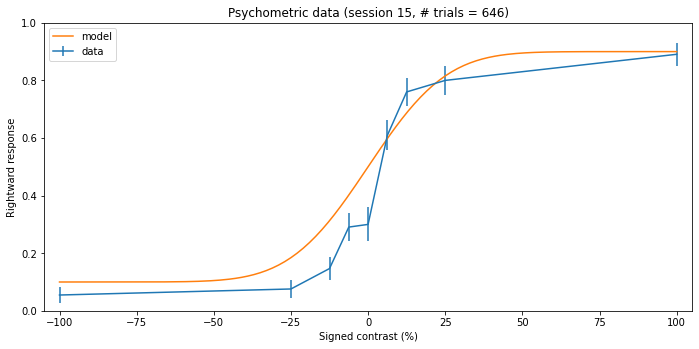

In [12]:
theta0 = (0,20,0.2,0.5) # Arbitrary parameter values - try different ones
session_num = 15
fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df,session_num)
psychofun_plot(theta0,ax)
plt.show()

We now define the log likelihood function of the psychometric function model for a given dataset and model parameter vector, $\log p(\text{data}|\mathbf{\theta})$.

In [13]:
def psychofun_loglike(theta,df):
    """Log-likelihood for psychometric function model"""
    s_vec = df['signed_contrast'] # Stimulus values
    r_vec = df['response_choice']  # Responses
    
    p_right = psychofun(theta,s_vec)
    
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike

Now try to get the best fit for this session, as we did before, but by finding better and better values of the log-likelihood.

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=836434, Fri Nov 12 12:51:24 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.128880689328271e+02 1.0e+00 4.39e-01  4e-01  5e-01 0:00.0
    2     16 3.034693104046488e+02 1.3e+00 4.79e-01  4e-01  6e-01 0:00.0
    3     24 3.092834374882259e+02 1.6e+00 4.14e-01  3e-01  5e-01 0:00.0
  100    800 2.986582727401147e+02 7.5e+01 4.32e-03  2e-05  1e-03 0:00.4
  112    896 2.986582721168629e+02 5.1e+01 1.44e-03  6e-06  2e-04 0:00.5
termination on tolfun=1e-05 (Fri Nov 12 12:51:24 2021)
final/bestever f-value = 2.986583e+02 2.986583e+02
incumbent solution: [-1.9761772523846743, 9.242688448301605, 0.13994445552520085, 0.6275325294738752]
std deviation: [0.00018210329146024914, 0.00024743052552152705, 5.657398133700859e-06, 2.0262980317261148e-05]
Log-likelihood value: -298.658


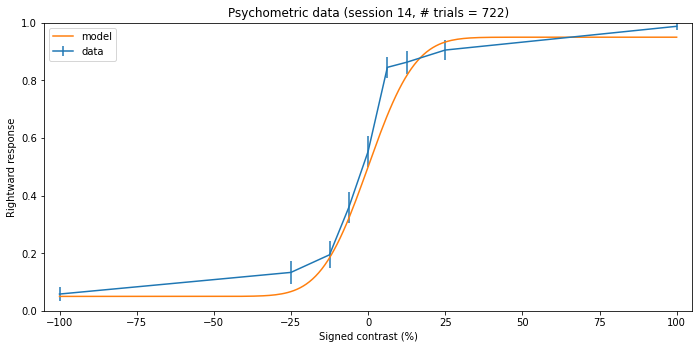

In [50]:
session_num = 14 # Let's use a different session

theta0 = (0,12,0.1,0.5) 

# Define objective function: negative log-likelihood
opt_fun = lambda theta_: -psychofun_loglike(theta_,df_session)

# Initialize CMA-ES algorithm
opts = cma.CMAOptions()
opts.set("bounds",bounds)
opts.set("tolfun",1e-5)

# Run optimization
res = cma.fmin(opt_fun, theta0, 0.5, opts)

ll = psychofun_loglike(res[0],df[df['session_num'] == session_num])

# ll = res
print('Log-likelihood value: ' + "{:.3f}".format(ll))
# print(res)
# print('Log-likelihood value: ' + ll)

fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df,session_num)
psychofun_plot(theta0,ax)
plt.show()

In [49]:
print(res)

(array([-1.97595362,  9.2424841 ,  0.13994369,  0.62755058]), 298.6582720688316, 801, 809, 101, array([-1.9759666 ,  9.24248456,  0.13994369,  0.62755267]), array([5.58159793e-05, 1.10753740e-04, 2.17894047e-06, 5.45203331e-06]), {'tolfun': 1e-05}, {'tolfun': 1e-05}, <cma.evolution_strategy.CMAEvolutionStrategy object at 0x7f84b050bca0>, <cma.logger.CMADataLogger object at 0x7f84cb71c490>)


**Maximum-likelihood estimation:**

In this section, we are going to estimate model parameters (aka fit our models) by maximizing the log-likelihood. By convention in optimization, we are going to *minimize* the negative log-likelihood.

Before running the optimization, we define the *hard* lower and upper bounds for the parameters. If the optimization algorithm supports constrained (bound) optimization, it will never go outside the hard bounds. We also define informally the *plausible* bounds as the range of parameters that we would expect to see. We are going to use the plausible range to initialize the problem later.

In [19]:
# Define hard parameter bounds
lb = np.array([-100,1,0,0])
ub = np.array([100,100,1,1])
bounds = [lb,ub]

# Define plausible range
plb = np.array([-25,5,0.05,0.2])
pub = np.array([25,25,0.40,0.8])

# Pick session data
session_num = 14
df_session = df[df['session_num'] == session_num]

# Define objective function: negative log-likelihood
opt_fun = lambda theta_: -psychofun_loglike(theta_,df_session)

We are now going to run a *black-box* optimization algorithm called CMA-ES. For now we are going to run the optimization only once, but in general you should *always* run the optimization from multiple distinct starting points.

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=803774, Fri Nov 12 12:26:11 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.380138507511315e+02 1.0e+00 5.13e-01  5e-01  6e-01 0:00.0
    2     16 3.502481838332940e+02 1.4e+00 5.54e-01  5e-01  6e-01 0:00.0
    3     24 3.460537246050626e+02 1.5e+00 6.01e-01  5e-01  7e-01 0:00.0
  100    800 2.986582723752051e+02 7.7e+01 6.37e-03  3e-05  1e-03 0:00.4
  116    928 2.986582720703106e+02 6.6e+01 1.02e-03  3e-06  1e-04 0:00.5
termination on tolfun=1e-05 (Fri Nov 12 12:26:12 2021)
final/bestever f-value = 2.986583e+02 2.986583e+02
incumbent solution: [-1.9759743520727033, 9.242591999962983, 0.13994217683456245, 0.627547291477469]
std deviation: [7.881709976571564e-05, 0.00012275380314018955, 2.589562139140393e-06, 7.05601819912105e-06]

Returned parameter vector: [-1.97597435  9.242592    0.13994218  0.62754729]
Negative log-likelihood at solution: 298.658272069507


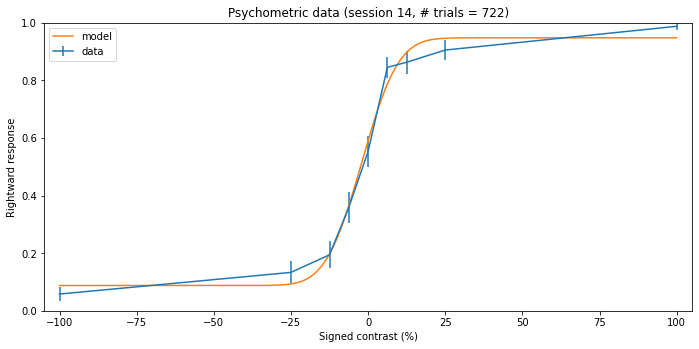

In [20]:
# Generate random starting point for the optimization inside the plausible box
theta0 = np.random.uniform(low=plb,high=pub) 

# Initialize CMA-ES algorithm
opts = cma.CMAOptions()
opts.set("bounds",bounds)
opts.set("tolfun",1e-5)

# Run optimization
res = cma.fmin(opt_fun, theta0, 0.5, opts)

print('')
print('Returned parameter vector: ' + str(res[0]))
print('Negative log-likelihood at solution: ' + str(res[1]))

fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df_session,session_num)
psychofun_plot(res[0],ax)
plt.show()

**Model comparison:**

We consider now a slightly more advanced model which includes time dependency by having the response in the current trial being influenced by the response in the previous trial. We adopt a simple model, `repeatlast`, in which the observer has a fixed chance of repeating the previous choice.

In [21]:
def psychofun_repeatlast_loglike(theta,df):
    """Log-likelihood for last-choice dependent psychometric function model"""
    s_vec = np.array(df['signed_contrast']) # Stimulus values
    r_vec = np.array(df['response_choice'])  # Responses
    
    p_last = theta[0] # Probability of responding as last choice
    theta_psy = theta[1:] # Standard psychometric function parameters
        
    p_right = psychofun(theta_psy,s_vec)
    
    # Starting from the 2nd trial, probability of responding equal to the last trial
    p_right[1:] = p_last*(r_vec[0:-1] == 1) + (1-p_last)*p_right[1:] 
    
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=829014, Fri Nov 12 12:26:15 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.836288432002927e+02 1.0e+00 4.81e-01  4e-01  5e-01 0:00.0
    2     16 4.006213609044975e+02 1.3e+00 4.69e-01  4e-01  5e-01 0:00.0
    3     24 3.797941080278096e+02 1.4e+00 4.65e-01  4e-01  5e-01 0:00.0
  100    800 2.805422891623072e+02 4.9e+01 3.22e-01  9e-03  4e-01 0:00.3
  159   1272 2.804863985611815e+02 4.9e+01 6.66e-04  3e-06  1e-04 0:00.4
termination on tolfun=1e-05 (Fri Nov 12 12:26:15 2021)
final/bestever f-value = 2.804864e+02 2.804864e+02
incumbent solution: [0.15168621039871294, -2.1094756574011027, 7.1808407480765135, 0.05690330638597413, 0.6223063614713638]
std deviation: [3.693059255978707e-06, 9.362645850754094e-05, 0.00014594919188287012, 3.2999035743765523e-06, 2.4087283463382038e-05]

Returned parameter vector: [ 0.15168621 -2.10947566  7.18084075  0.05690331  0.62230636]
Negative log-likeli

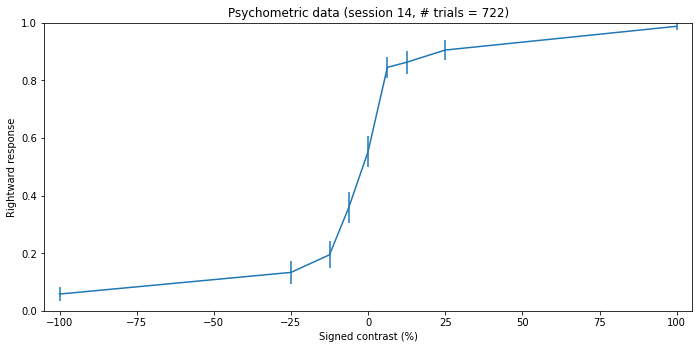

In [22]:
lb = np.array([0,-100,1,0,0])
ub = np.array([1,100,100,1,1])
bounds = [lb,ub]

plb = np.array([0.05,-25,5,0.05,0.2])
pub = np.array([0.2,25,25,0.45,0.8])

df_session = df[df['session_num'] == session_num]
# df_session = df[(df['session_num'] == session_num) & (df['trial_num'] > 300)]
opt_fun = lambda theta_: -psychofun_repeatlast_loglike(theta_,df_session)

theta0 = np.random.uniform(low=plb,high=pub)
opts = cma.CMAOptions()
opts.set("bounds",bounds)
opts.set("tolfun",1e-5)
res_repeatlast = cma.fmin(opt_fun, theta0, 0.5, opts)

print('')
print('Returned parameter vector: ' + str(res_repeatlast[0]))
print('Negative log-likelihood at solution: ' + str(res_repeatlast[1]))

fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df_session,session_num)
#psychofun_plot(res[0],ax)
plt.show()

We now calculate a few model simple comparison metrics, such as AIC and BIC, for the `basic` and `repeatlast` models.

In [23]:
Nmodels = 2
nll = np.zeros(Nmodels)
nparams = np.zeros(Nmodels)

results = [res,res_repeatlast] # Store all optimization output in a vector

for i in range(0,len(results)):
    nll[i] = results[i][1] # The optimization algorithm received the *negative* log-likelihood
    nparams[i] = len(results[i][0])

ntrials = len(df['signed_contrast'])

aic = 2*nll + 2*nparams
bic = 2*nll + nparams*np.log(ntrials)

print('Model comparison results (for all metrics, lower is better)\n')
print('Negative log-likelihoods: ' + str(nll))
print('AIC: ' + str(aic))
print('BIC: ' + str(bic))

Model comparison results (for all metrics, lower is better)

Negative log-likelihoods: [298.65827207 280.48639856]
AIC: [605.31654414 570.97279712]
BIC: [634.28002245 607.177145  ]


### [Advanced] Optional model:

We consider next a more advanced model which includes explicit time dependency (the trials are not all the same), also known as *non-stationarity*. Note that this function is not coded very efficiently and runs quite slowly due to the `for` loop - it could be improved with vectorization.

In [24]:
def psychofun_timevarying_loglike(theta,df):
    """Log-likelihood for time-varying psychometric function model"""
    s_vec = np.array(df['signed_contrast']) # Stimulus values
    r_vec = np.array(df['response_choice'])  # Responses
    
    Ntrials = len(s_vec)
    mu_vec = np.linspace(theta[0],theta[4],Ntrials)
    sigma_vec = np.linspace(theta[1],theta[5],Ntrials)
    lapse_vec = np.linspace(theta[2],theta[6],Ntrials)
    lapsebias_vec = np.linspace(theta[3],theta[7],Ntrials)
    
    p_right = np.zeros(Ntrials)
    
    for t in range(0,Ntrials):
        p_right[t] = psychofun([mu_vec[t],sigma_vec[t],lapse_vec[t],lapsebias_vec[t]],s_vec[t])
    
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike

theta0 = (0,20,0.1,0.5,1,20,0.1,0.5)
ll = psychofun_timevarying_loglike(theta0,df[df['session_num'] == session_num])

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=849281, Fri Nov 12 17:06:28 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 3.581353890451362e+02 1.0e+00 4.55e-01  4e-01  5e-01 0:00.5
    2     20 3.445983622399359e+02 1.2e+00 4.51e-01  4e-01  5e-01 0:01.1
    3     30 3.508974395836067e+02 1.3e+00 4.46e-01  4e-01  5e-01 0:01.7
    9     90 3.486654753367039e+02 1.6e+00 3.44e-01  3e-01  4e-01 0:05.0
   17    170 3.427489485266310e+02 2.4e+00 2.76e-01  2e-01  3e-01 0:09.2
   27    270 3.369616443012926e+02 3.0e+00 2.31e-01  1e-01  3e-01 0:14.2
   39    390 3.345986132195401e+02 5.1e+00 1.77e-01  7e-02  3e-01 0:20.3
   53    530 3.312605347997097e+02 1.0e+01 1.26e-01  3e-02  2e-01 0:27.5
   69    690 3.244291394210790e+02 1.6e+01 5.02e-01  8e-02  9e-01 0:35.6
   87    870 3.058638529786064e+02 3.7e+01 4.99e-01  5e-02  1e+00 0:44.7
  100   1000 3.017324844378434e+02 4.0e+01 5.69e-01  5e-02  1e+00 0:51.3
  122   1220 2.957504509635334e+02

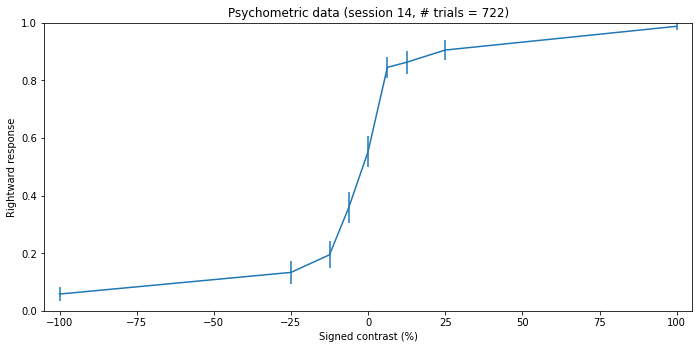

In [120]:
lb = np.array([-100,1,0,0,-100,1,0,0])
ub = np.array([100,100,1,1,100,100,1,1])
bounds = [lb,ub]

plb = np.array([-25,5,0.05,0.2,-25,5,0.05,0.2])
pub = np.array([25,25,0.45,0.8,25,25,0.45,0.8])

session_num = 14
df_session = df[df['session_num'] == session_num]
# df_session = df[(df['session_num'] == session_num) & (df['trial_num'] > 300)]
opt_fun = lambda theta_: -psychofun_timevarying_loglike(theta_,df_session)

theta0 = np.random.uniform(low=plb,high=pub)
opts = cma.CMAOptions()
opts.set("bounds",bounds)
opts.set("tolfun",1e-5)
res_time = cma.fmin(opt_fun, theta0, 0.5, opts)

print('')
print('Returned parameter vector: ' + str(res_time[0]))
print('Negative log-likelihood at solution: ' + str(res_time[1]))

fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df_session,session_num)
#psychofun_plot(res[0],ax)
plt.show()

## Your assignment

So far, we've expected the animal's choice data on a simple task, where the only relevant information is the stimulus (i.e. signed contrast). Below is data from a more complex version of the task, where the probability of the stimulus appearing on the left vs. right side changes between blocks.

In [99]:
df_blocks = pd.read_csv('https://raw.githubusercontent.com/anne-urai/tics-2020-tutorial/master/data/KS014_biased.csv') 

# signed contracst = contrast X position.
# ie., posistion = left and contrast = 50 => Signed_contrast = -1 X 50 = -50
df_blocks['signed_contrast'] = df_blocks.contrast * df_blocks.position

In [138]:
# df_blocks.head()
# df.session_num[]()
df.loc[df['session_num'] == 12]
# df.loc[df['column_name'] == some_value]
# in df.groupby(['gw_mac','mac'])

,trial_num,session_num,contrast,position,response_choice,trial_correct,reaction_time,signed_contrast,Group
7514,1,12,25.0,1.0,1,1.0,1.059000,25.0,0
7515,2,12,25.0,1.0,1,1.0,0.356500,25.0,1
7516,3,12,25.0,1.0,1,1.0,0.627200,25.0,2
7517,4,12,50.0,-1.0,-1,1.0,0.235000,-50.0,3
7518,5,12,50.0,1.0,1,1.0,0.364100,50.0,4
...,...,...,...,...,...,...,...,...,...
8280,767,12,50.0,1.0,-1,0.0,5.798801,50.0,766
8281,768,12,12.5,1.0,-1,0.0,1.692801,12.5,767
8282,769,12,12.5,1.0,-1,0.0,0.650801,12.5,768
8283,770,12,12.5,1.0,-1,0.0,0.739401,12.5,769


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=427357, Fri Nov 19 13:20:57 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 4.830386466129266e+02 1.0e+00 4.80e-01  5e-01  5e-01 0:00.0
    2     20 4.821373668589309e+02 1.2e+00 4.35e-01  4e-01  4e-01 0:00.0
    3     30 4.828131151830447e+02 1.3e+00 4.06e-01  4e-01  4e-01 0:00.0
  100   1000 4.819081864377741e+02 1.0e+01 1.26e+00  8e-01  2e+00 0:00.5
  200   2000 4.817036928452081e+02 4.8e+01 1.47e+00  9e-01  2e+00 0:01.1
  300   3000 4.818271257874816e+02 1.4e+02 4.90e+00  4e+00  1e+01 0:01.6
  400   4000 4.827515500613346e+02 1.7e+02 1.33e+01  7e+00  2e+01 0:02.1
  500   5000 4.851399457105836e+02 2.3e+02 4.62e+00  1e+00  5e+00 0:02.6
  600   6000 4.830866521166808e+02 5.8e+02 2.79e+00  5e-01  3e+00 0:03.1
  700   7000 4.822604398265963e+02 2.5e+03 2.51e+00  2e-01  4e+00 0:03.7
  710   7100 4.930556415559145e+02 2.8e+03 3.80e+00  4e-01  5e+00 0:03.7
termination on tolstagnation=321 (

<Figure size 648x288 with 0 Axes>

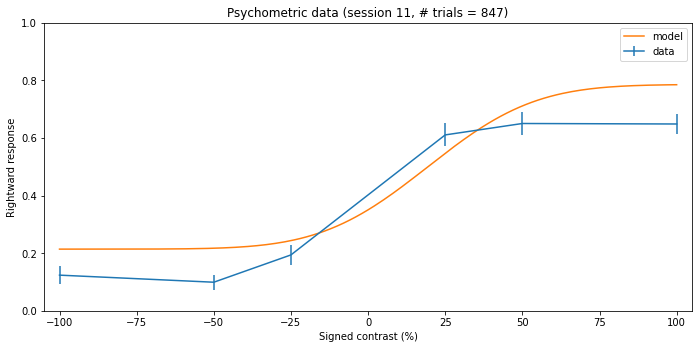

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=395911, Fri Nov 19 13:21:02 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 3.472018830211429e+02 1.0e+00 4.73e-01  5e-01  5e-01 0:00.0
    2     20 3.472361418599869e+02 1.2e+00 4.45e-01  4e-01  4e-01 0:00.0
    3     30 3.461636963544909e+02 1.3e+00 4.20e-01  4e-01  4e-01 0:00.0
  100   1000 3.361318991277194e+02 1.9e+02 1.80e+00  3e-02  3e+00 0:00.5
  200   2000 3.360988439790669e+02 4.9e+03 1.84e-02  1e-05  3e-02 0:01.0
  201   2010 3.360988439868545e+02 5.6e+03 1.91e-02  9e-06  3e-02 0:01.0
termination on tolfun=1e-05 (Fri Nov 19 13:21:03 2021)
final/bestever f-value = 3.360988e+02 3.360988e+02
incumbent solution: [-11.707431050334112, 20.961539584538976, 0.25201934983356405, 0.9750979483943882, 0.7990793922685315, 18.720162551460973, 0.985471928104383, 0.8735076145764644]
std deviation: [0.0009005790121373908, 0.0011462557288455125, 9.304355822793887e-06, 0.0317607831356385, 0.0181

<Figure size 648x288 with 0 Axes>

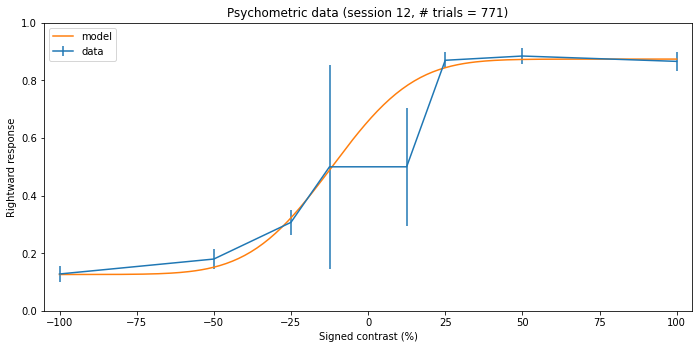

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=407161, Fri Nov 19 13:21:03 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.294478071941798e+02 1.0e+00 5.29e-01  5e-01  6e-01 0:00.0
    2     20 2.298551266771414e+02 1.4e+00 5.81e-01  5e-01  6e-01 0:00.0
    3     30 2.339005326156650e+02 1.5e+00 6.45e-01  6e-01  7e-01 0:00.0
  100   1000 2.005549986104735e+02 9.7e+01 2.91e-01  8e-03  6e-01 0:00.6
  172   1720 2.005367834857792e+02 2.3e+03 1.14e-02  1e-05  2e-02 0:01.0
termination on tolfun=1e-05 (Fri Nov 19 13:21:04 2021)
final/bestever f-value = 2.005368e+02 2.005368e+02
incumbent solution: [-4.244874064063376, 9.60475401372186, 0.0822637075508708, 0.13232125731997846, 7.611324588873955, 16.846777131124654, 0.3018360176072745, 0.7393616306298675]
std deviation: [0.0006734461823254373, 0.0011195783897999544, 1.4447882576383734e-05, 0.021517714893208015, 0.011554636942743545, 0.00934602724632035, 0.023754802191319004, 0.020481490221

<Figure size 648x288 with 0 Axes>

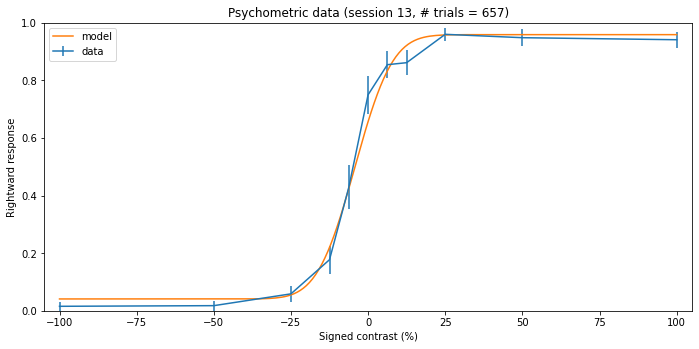

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=363335, Fri Nov 19 13:21:05 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 3.085246251324984e+02 1.0e+00 4.77e-01  5e-01  5e-01 0:00.0
    2     20 3.071721404669128e+02 1.2e+00 4.70e-01  4e-01  5e-01 0:00.0
    3     30 3.092016356173935e+02 1.3e+00 4.53e-01  4e-01  5e-01 0:00.0
  100   1000 2.994422708018220e+02 1.6e+02 4.19e-01  7e-03  6e-01 0:00.5
  171   1710 2.994335879053387e+02 2.7e+03 5.67e-03  7e-06  1e-02 0:00.9
termination on tolfun=1e-05 (Fri Nov 19 13:21:06 2021)
final/bestever f-value = 2.994336e+02 2.994336e+02
incumbent solution: [-2.7056393351468513, 9.266324227910948, 0.13702069735628788, 0.5220116143837197, -5.767338460879587, 21.81096926169375, 0.4386942928968969, 0.705597502885891]
std deviation: [0.00017793292658594185, 0.0003519160745842545, 7.4996578407082685e-06, 0.004035920395318334, 0.00864769375389052, 0.010882704313834788, 0.012852884310501007, 0.0050185071

<Figure size 648x288 with 0 Axes>

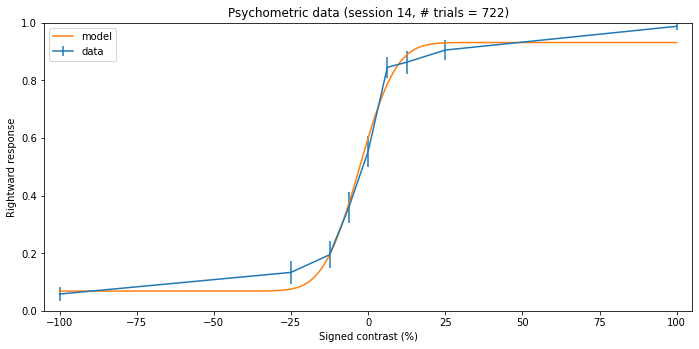

In [14]:
def optimize_model(obj_func):
    lb = np.array([-100,1,0,0,-100,1,0,0])
    ub = np.array([100,100,1,1,100,100,1,1])
    bounds = [lb,ub]

    plb = np.array([-25,5,0.05,0.2,-25,5,0.05,0.2])
    pub = np.array([25,25,0.45,0.8,25,25,0.45,0.8])
    
    opts = cma.CMAOptions()
    opts.set("bounds",bounds)
    opts.set("tolfun",1e-5)
    # opts.set("maxfevals", 30)
    opts.set("maxiter", 3000)
    
    theta0 = np.random.uniform(low=plb,high=pub)
    res = cma.fmin(obj_func, theta0, 0.5, opts)

    theta = res[0]
    return theta

def succes_rates(session_num=15):
    fig1 =  plt.figure(figsize=(9,4))
    
    
    trial_mask = df['session_num'] == session_num # Indexes of trials of the chosen session
    n_trials = np.sum(trial_mask) # Number of chosen trials
    masked_df = df[trial_mask]
    
    mean_of_trials = []
    for curr_trial in range(1, n_trials+1):
        trial_mean = masked_df.loc[masked_df['trial_num'] <= curr_trial ].trial_correct.mean() # Calculate the mean for every trial that has been done until now
        mean_of_trials.append(trial_mean)
    
    return mean_of_trials 



def psycho_func(theta,stim):
    """Psychometric function based on normal CDF and lapses"""
    mu = theta[0]          # bias
    sigma = theta[1]       # slope/noise
    lapse = theta[2]       # lapse rate
    if len(theta) == 4:    # lapse bias
        lapse_bias = theta[3];
    else:
        lapse_bias = 0.5   # if theta has only three elements, assume symmetric lapses
    
    p_right = norm.cdf(stim,loc=mu,scale=sigma)    # Probability of responding "rightwards", without lapses
    p_right = lapse*lapse_bias + (1-lapse)*p_right # Adding lapses

    return p_right


def calculate_loglike(theta, df):
    """Log-likelihood for psychometric function model"""
    s_vector = df['signed_contrast'] # Stimulus values
    r_vector = df['response_choice'] # Responses
    p_right = psycho_func(theta, s_vector)
    
    loglike = np.sum(np.log(p_right[r_vector == 1])) + np.sum(np.log(1 - p_right[r_vector == -1]))

    return loglike

def plot_psycho_func(theta, ax, optimize=False, session_num=14):
    """Plot psychometric function"""
    df_session = df[df['session_num'] == session_num]
    stim_grid = np.linspace(-100,100,201) # Stimulus grid for plotting
    
    if optimize:
        obj_func = lambda theta: -calculate_loglike(theta,df_session)
        theta = optimize_model(obj_func)
    
    p_right = psycho_func(theta,stim_grid) # Calculate psychometric function values
    ax.plot(stim_grid, p_right, label='model')
    ax.legend()
    return 
    

def plot_psycho_data(df, session_num=14, ax=None, fig=None):
    """Plot psychometric data"""
    
    trial_mask = df['session_num'] == session_num # Indexes of trials of the chosen session
    Ntrials = np.sum(trial_mask) # Number of chosen trials
    
    left_resp = df[(df['response_choice'] == -1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']
    right_resp = df[(df['response_choice'] == 1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']    
    
    
    frac_resp = right_resp / (left_resp + right_resp)
    err_bar = np.sqrt(frac_resp*(1-frac_resp)/(left_resp + right_resp)) # Why this formula for error bars?
    
    if fig == None:
        fig = plt.figure(figsize=(9,4))
    ax = fig.add_axes([0,0,1,1])

    
    ax.errorbar(x=left_resp.index,y=frac_resp,yerr=err_bar,label='data');
    ax.set_xlabel('Signed contrast (%)')
    ax.set_ylabel('Rightward response')
    
    
    ax.set_title('Psychometric data (session ' + str(session_num) + ', # trials = ' + str(Ntrials) + ')')        
    plt.xlim((-105,105))
    plt.ylim((0,1))
    return ax

def plot_fitted_psychometric(session_num=14, optimize=False):
    theta0 = (0, 20, 0.2, 0,5)
    
    fig = plt.figure(figsize=(9,4))
    ax = plot_psycho_data(df, session_num, fig)
    plot_psycho_func(theta0, ax, optimize=optimize, session_num=session_num)
    plt.show()
    
def plot_multiple_avgs():
    """
    For every session in the dataset 'KS014_train':
    * Plot a graph that shows the average until now for every trial in that session
    """
    total_sessions = df['session_num'].max()
    max_trial = df['trial_num'].max()
    plt.figure(figsize=(25, 15))
    plt.xlabel('Trials', fontsize=14)
    plt.ylabel('Average correct responses so far', fontsize=14)
    plt.title('Average correct responses so far for every trial in a certain session', fontsize=20)
    ax1 = plt.subplot()
    ax1.set(xlim=(0,max_trial), ylim=(0,1))
    trial_labels = [] 
    
    for i in range(7, total_sessions+1): # for i in range(1, total_sessions+1) vervangen door => for i in range(first_session, total_sessions+1)
        trial_label = f"session {i}"
        trial_labels.append(trial_label)
        trial_means = succes_rates(i)
        line, = ax1.plot(trial_means,linewidth=2.5, alpha=1)
    ax.legend(trial_labels)
    
def plot_multiple_fitted_psycho(min=1, max=4, optimize=True):
    for session_num in range(min,max+1):
        plot_fitted_psychometric(session_num=session_num, optimize=optimize)
        
    
# plot_multiple_avgs() # Call this function to plot the average correct trials for certain sessions
# plot_fitted_psychometric(True) # Try to fit a psychometric function and plot it
plot_multiple_fitted_psycho(min=11, max=14, optimize=True)

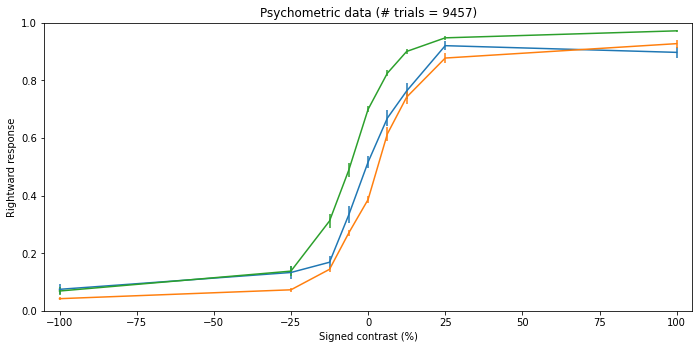

In [28]:
fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df_blocks[df_blocks['stim_probability_left'] == 0.5])
plot_psychometric_data(df_blocks[df_blocks['stim_probability_left'] == 0.8], ax=ax)
plot_psychometric_data(df_blocks[df_blocks['stim_probability_left'] == 0.2], ax=ax)
plt.show()